<a href="https://colab.research.google.com/github/mainarel/Numerical_methods_7/blob/main/Lab3_minimal_residual_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.sparse import csr_matrix

Заполнение матрицы, границы области, шаг сетки:

In [140]:
xmin = 0
xmax = 1
ymin = 0
ymax = 2

**Условия задачи:** \\
*Используя метод минимальных невязок найти решение СЛАУ, возникающей при разностной аппроксимации задачи Дирихле для двумерного уравнения Пуассона в прямоугольнике.
Даны точные решения.* \\
$$ u(x,y) = 5(-3x+4y)cos(5x+2y)+3y^2 \\
0 \leq x \leq 1, \\ 0 \leq y \leq 2 
$$
*Вычислим производные:*
$$
u_{xx} = 150sin(5x+2y) - 125cos(5x+2y)(-3x+4y) \\
u_{yy} = -80sin(5x+2y)-20cos(5x+2y)(-3x+4y)+6 \\
f(x,y)=u_{xx} + u_{yy}  = 70sin(5x+2y)-145cos(5x+2y)(-3x+4y)+6
$$

*Ограничения:*
$$
\begin{cases}
u(0, y)=\mu(0, y)=\mu_{x}^{(1)}(y) = 20y cos(2y)+3y^2
\\
u(1, y)=\mu(1, y)=\mu_{x}^{(2)}(y) = (-15+20y)cos(5+2y)+3y^2
\\
u(x, 0)=\mu(x, 0)=\mu_{y}^{(1)}(x) = -15xcos(5x)
\\
u(x, 2)=\mu(x, 2)=\mu_{y}^{(2)}(x) = (-15x+40)cos(5x+4)+12
\end{cases}
$$

Граничные условия, аналитическое решение:


In [141]:
def f(x,y):
  return 70*np.sin(5*x+2*y)-145*np.cos(5*x+2*y)*(-3*x+4*y)+6

def solution(x,y):
  return 5*(-3*x+4*y)*np.cos(5*x+2*y)+3*y**2
    
def mu1_x(y):
    return 20*y*np.cos(2*y)+3*y**2

def mu2_x(y):
    return (-15+20*y)*np.cos(5+2*y)+3*y**2

def mu1_y(x):
    return -15*x*np.cos(5*x)

def mu2_y(x):
    return (-15*x+40)*np.cos(5*x+4)+12


Дополнительные функции:

In [122]:
#число обусловленности
def condition_number(A):  
    return np.linalg.cond(A)

# #ошибка
# def error(array):
#   real_array = np.linalg.solve(A, B)
#   return np.linalg.norm(real_array-array)

# #невязка
# def delta(array):
#   return np.linalg.norm(np.dot(A, array) - B.T)


Метод наименьших невязок:

In [142]:
def min_residual_method(A,B, epsilon = 1e-10):
        n = len(A.toarray())
        x = np.ones(n)
        Ax = A.dot(x)
        first_norm = np.linalg.norm(Ax - B)
        norm = first_norm
        count = 0
        while norm > epsilon*first_norm:
            count += 1
            r = Ax - B
            Ar = A.dot(r)
            tau = Ar.dot(r) / Ar.dot(Ar)
            x = x - tau * r
            Ax = A.dot(x)
            norm = np.linalg.norm(Ax - B)
        return x, count

In [143]:
def LaplasianEquation(f, mu1_x, mu2_x, mu1_y, mu2_y, xmin=0, xmax=1, ymin=0, ymax=2, hx=0.01, hy=0.01):
        x = np.arange(xmin+hx, xmax, hx)
        y = np.arange(ymin+hy, ymax, hy)
        u = np.zeros((len(x), len(y)))

        A = np.zeros((len(x)*len(y), len(x)*len(y)))
        B = np.zeros(len(x)*len(y))

        for j in range(len(y)):
            for i in range(len(x)):
                A[j*len(x) + i, j*len(x) + i] = 2*(hx**2 + hy**2)
                B[j*len(x) + i] = -f(x[i], y[j]) * hx**2 * hy**2
                if j == 0:
                    A[j*len(x) + i][(j+1)*len(x) + i] = -hx**2 
                    B[j*len(x) + i] += mu1_y(x[i]) * hx**2
                elif j == len(y) - 1:
                    A[j*len(x) + i][(j-1)*len(x) + i] = -hx**2
                    B[j*len(x) + i] += mu2_y(x[i]) * hx**2
                else:
                    A[j*len(x) + i][(j-1)*len(x) + i] = -hx**2
                    A[j*len(x) + i][(j+1)*len(x) + i] = -hx**2

                if i == 0:
                    A[j*len(x) + i][j*len(x) + i + 1] = -hy**2
                    B[j*len(x) + i] += mu1_x(y[j]) * hy**2
                elif i == len(x) - 1:
                    A[j*len(x) + i][j*len(x) + i - 1] = -hy**2
                    B[j*len(x) + i] += mu2_x(y[j]) * hy**2
                else:
                    A[j*len(x) + i][j*len(x) + i - 1] = -hy**2
                    A[j*len(x) + i][j*len(x) + i + 1] = -hy**2

        A = csr_matrix(A.copy())   
        u, k = min_residual_method(A, B)      
        return u 

In [144]:
u =  LaplasianEquation(f, mu1_x, mu2_x, mu1_y, mu2_y, xmin=0, xmax=1, ymin=0, ymax=2, hx=0.01, hy=0.01)

In [145]:
hx0 = 0.01
hy0 = 0.01 

x0 = np.arange(xmin+hx0, xmax, hx0)
y0 = np.arange(ymin+hy0, ymax, hy0)

In [146]:
sol = np.array([solution(i, j) for j in y0 for i in x0])
SOL = sol.reshape((len(y0), len(x0))).T
U = u.reshape((len(y0), len(x0))).T

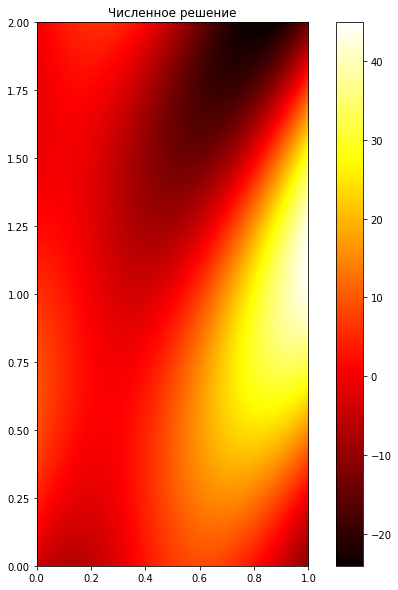

In [147]:
plt.figure(figsize=(10,10))
plt.imshow(U, extent=[xmin, xmax, ymin, ymax], cmap='hot', interpolation='bilinear')
plt.colorbar()
plt.title("Численное решение")
plt.show()

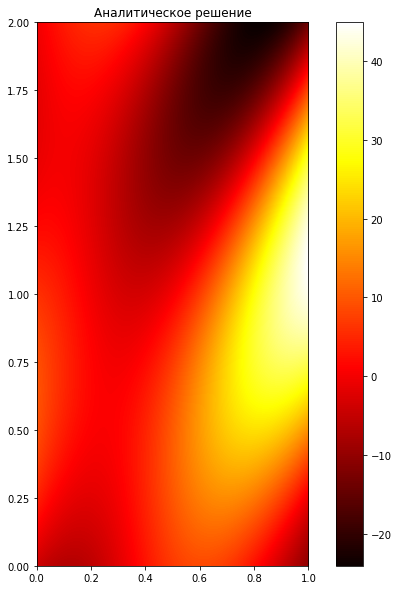

In [148]:
plt.figure(figsize=(10,10))
plt.title("Аналитическое решение")
plt.imshow(SOL, extent=[xmin, xmax, ymin, ymax], cmap='hot', interpolation='bilinear')
plt.colorbar()
plt.show()

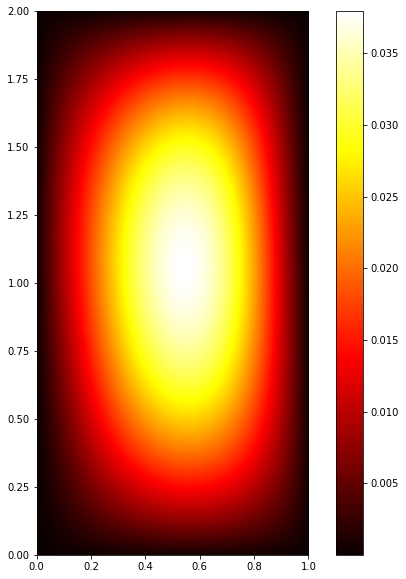

In [138]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(U-SOL), extent=[xmin, xmax, ymin, ymax], cmap='hot', interpolation='bilinear')
plt.colorbar()
plt.show()

In [ ]:
error = np.max(np.abs(U - SOL))
error

0.0038902060722332266